# Notebook creates a csv file for temperature-dependent fitting algorithms and merges the lowess single fit files into one file


### create `fit_data_temp_evol_global_regional_oggm_pygem_glogem_oct182023.csv`

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
matplotlib.rcParams['figure.figsize'] = (14, 8)

In [2]:
######################
rgi_regs_global = ['global','01', '02', '03', '04', '05', '06', '07',
                   '08', '09', '10', '11', '12', '13', '14', '15',
                   '16', '17', '18', '19']
rgi_regs_global.append('13-14-15')
path_oggm = 'glacier_model_csv_files/OGGM/'
path_glogem = 'glacier_model_csv_files/GloGEM/'
path_pygem =  'glacier_model_csv_files/PyGEM-OGGM/'

path_d = {}
path_d['OGGM']  = path_oggm
path_d['GloGEM'] = path_glogem
path_d['PyGEM-OGGM'] = path_pygem

colors_temp_values = {'+1.5°C':1.5,'+2.0°C':2.0,'+3.0°C':3.0, '+4.0°C':4.0} #, '>4.0°C':5.0}
from matplotlib.colors import LinearSegmentedColormap
colors_temp4_l = ['cornflowerblue', 'gold', 'orange', 'darkorange', 'crimson', '#980002', '#980002', '#980002']
cmap_blue_orange = LinearSegmentedColormap.from_list('bins_100',colors_temp4_l, N=1000)


In [4]:
# this is where we extracted the global climate change data from:
# https://cluster.klima.uni-bremen.de/~oggm/oggm-standard-projections/analysis_notebooks/global_gcm_climate_cmip6_cmip5.ipynb
try:
    import oggm
    dpath = 'https://cluster.klima.uni-bremen.de/~oggm/oggm-standard-projections/analysis_notebooks'
    _file_cmip5 = oggm.utils.file_downloader(f'{dpath}/Global_mean_temp_deviation_2071_2100_2081_2100_2271_2300_2281_2300_rel_1850_1900_cmip5_gcms.csv',
                                             reset=True)
    _file_cmip6 = oggm.utils.file_downloader(f'{dpath}/Global_mean_temp_deviation_2071_2100_2081_2100_2271_2300_2281_2300_rel_1850_1900_cmip6_gcms.csv',
                                             reset=True)
except:
    # you can also just download the file, 
    # e.g. via https://cluster.klima.uni-bremen.de/~oggm/oggm-standard-projections/analysis_notebooks/Global_mean_temp_deviation_2071_2100_2081_2100_2271_2300_2281_2300_rel_1850_1900_cmip5_gcms.csv
    # change this path to your local path 
    _file_cmip5 = 'change_to_local_path'
    _file_cmip6 = 'change_to_local_path'
pd_cmip5_temp_ch_2100 = pd.read_csv(_file_cmip5, index_col=0)
pd_cmip5_temp_ch_2100['cmip'] = 'CMIP5'
pd_cmip6_temp_ch_2100 = pd.read_csv(_file_cmip6, index_col=0)
pd_cmip6_temp_ch_2100['cmip'] = 'CMIP6'

pd_cmip_temp_ch_2100 = pd.concat([pd_cmip6_temp_ch_2100, pd_cmip5_temp_ch_2100])
pd_cmip_temp_ch_2100 = pd_cmip_temp_ch_2100.loc[pd_cmip_temp_ch_2100.ssp != 'ssp534-over']
pd_cmip_temp_ch_2100_gcm_until_2300 = pd_cmip_temp_ch_2100.loc[pd_cmip_temp_ch_2100['global_temp_ch_2271-2300_preindustrial'].dropna().index]

from sklearn.preprocessing import MinMaxScaler
data_temp = pd_cmip_temp_ch_2100_gcm_until_2300['global_temp_ch_2071-2100_preindustrial'].values.reshape(1,-1).T
scaler = MinMaxScaler()
scaler.fit(data_temp)
t_min, t_max = pd_cmip_temp_ch_2100_gcm_until_2300['global_temp_ch_2071-2100_preindustrial'].min(), pd_cmip_temp_ch_2100_gcm_until_2300['global_temp_ch_2071-2100_preindustrial'].max()
print(t_min, t_max)

1.427504187860568 6.274634111566688


['global' 'RGI01' 'RGI02' 'RGI03' 'RGI04' 'RGI05' 'RGI06' 'RGI07' 'RGI08'
 'RGI09' 'RGI10' 'RGI11' 'RGI12' 'RGI13' 'RGI14' 'RGI15' 'RGI16' 'RGI17'
 'RGI18' 'RGI19' 'RGI13-14-15']
1.427504187860568 6.274634111566688
['OGGM' 'PyGEM-OGGM' 'GloGEM']
0.0 273.0386630795257
2000 2300


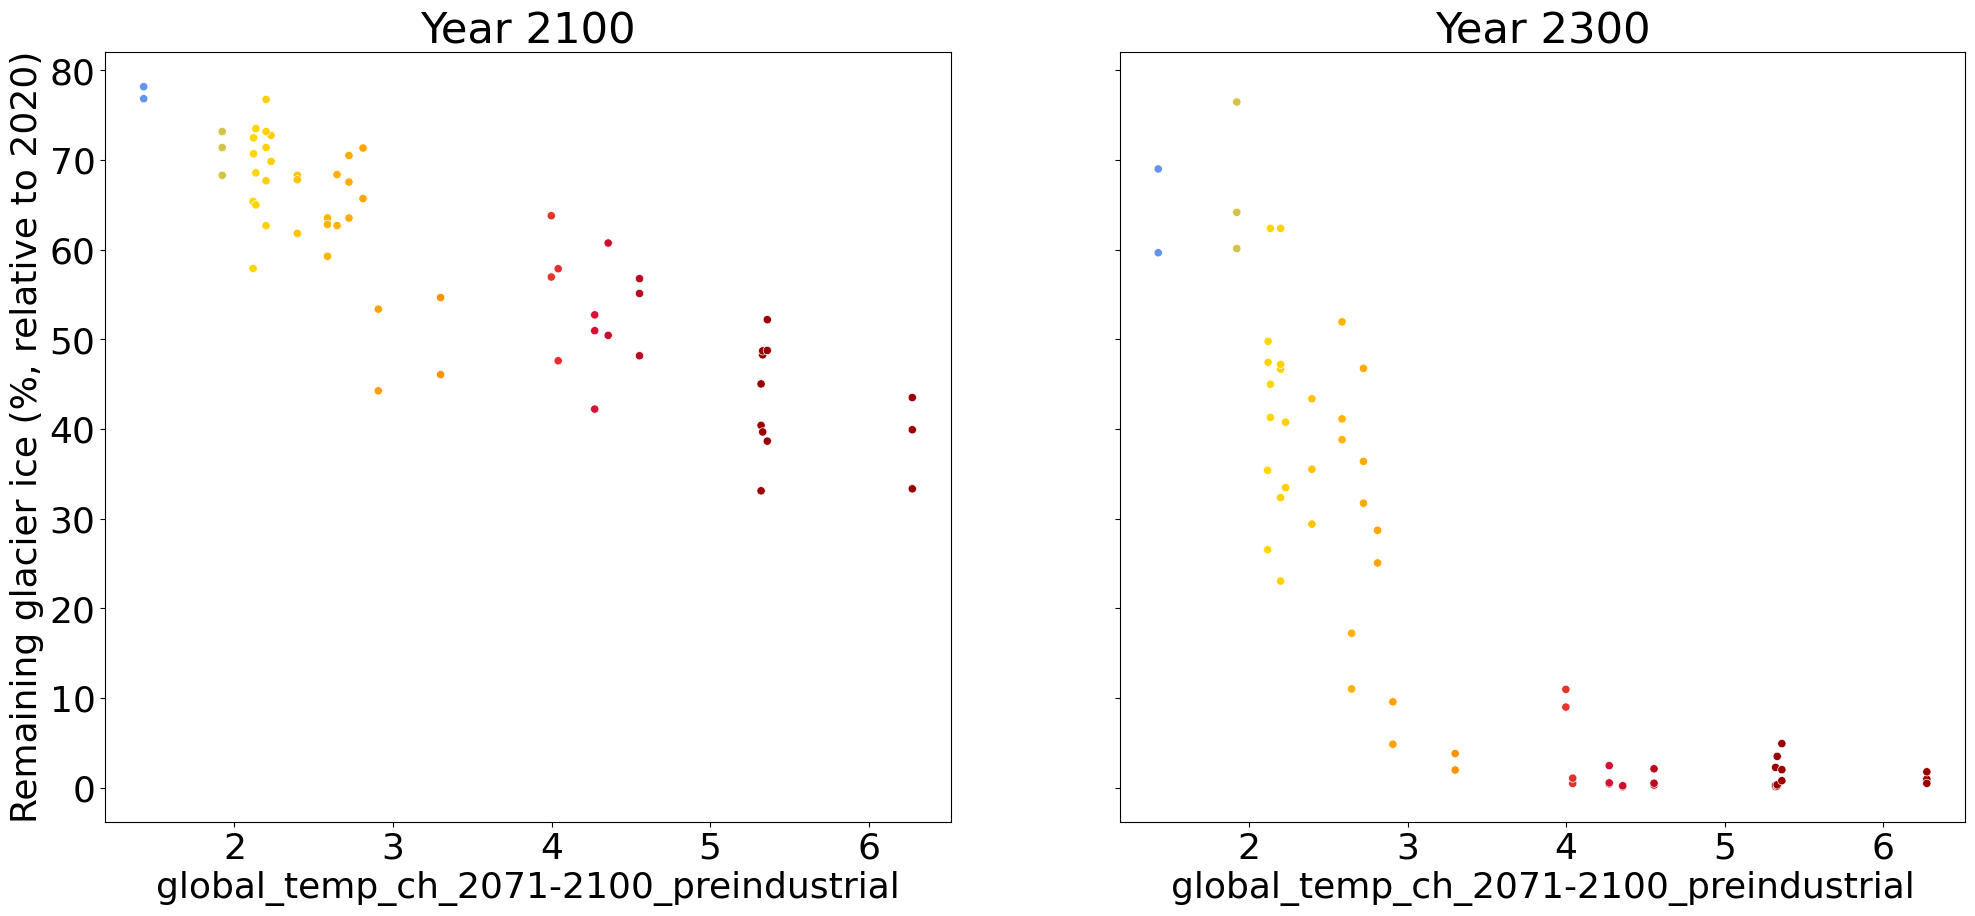

In [16]:
load = False
if load:
    end_year = '2300'
    pd_fit_data_reg_l = []
    for jj,_rgi_reg in enumerate(rgi_regs_global): 
        _pd_fit_data_l = []
        if _rgi_reg !='global':
            rgi_reg = f'RGI{_rgi_reg}'
        else:
            rgi_reg = _rgi_reg 
        # we sort it here into temperature levels, but we don't use that later anymore 
        colors_temp = {'<=+1.5°C':'cyan','<=+2.0°C':'blue','<=+3.0°C':'orange', '<=+4.0°C':'red', '>4.0°C':'purple'}
        for temp_lev in colors_temp.keys():
            df_rel_l = []
            
            for cmip in ['CMIP5','CMIP6']:
                pd_cmip = pd_cmip_temp_ch_2100_gcm_until_2300.loc[pd_cmip_temp_ch_2100_gcm_until_2300.ssp != 'ssp534-over']
                pd_cmip = pd_cmip.loc[pd_cmip.cmip == cmip]
                # check that there are temperature values in 2300 available ... 
                pd_cmip = pd_cmip.loc[pd_cmip['global_temp_ch_2271-2300_preindustrial'].dropna().index]
                for gcm_scenario in pd_cmip.index:
                    for m in path_d.keys():
                        try:
                            _pd_fit_data = pd.DataFrame(columns=['global_temp_ch_2071-2100_preindustrial','region', 'year', 'rel_ice_%_2020'])

                            gcm, scenario = gcm_scenario.split('_')
                            path = path_d[m]
                            gcm_scenario_m = gcm_scenario + '_' + m
                            n = len(gcm_scenario)
                            if _rgi_reg == '13-14-15':
                                df = 0
                                for sub_rgi_reg in ['RGI13','RGI14','RGI15']:
                                    idir = path + f'volume/{cmip}/{end_year}/{sub_rgi_reg}/'
                                    _df = pd.read_csv(idir + f'{scenario}.csv', index_col=0)
                                    _df.columns = [g.upper() for g in _df.columns]
                                    _df = _df[gcm.upper()]
                                    df += _df
                            else:
                                idir = path  + f'volume/{cmip}/{end_year}/{rgi_reg}/'
                                df = pd.read_csv(idir + f'{scenario}.csv', index_col=0)
                                df.columns = [g.upper() for g in df.columns]
                                df = df[gcm.upper()]

                            df = df.loc[2000:]
                            # first do the rolling than the relative estimates .. 
                            df_roll = df.rolling(20, center=True, min_periods=1).mean().dropna()
                            df_rel_roll = 100*df_roll/df_roll.loc[2020]
                            _pd_fit_data.year = df_rel_roll.index.astype(int)
                            _pd_fit_data['rel_ice_%_2020'] = df_rel_roll.values
                            _pd_fit_data['global_temp_ch_2071-2100_preindustrial'] = pd_cmip.loc[gcm_scenario, 'global_temp_ch_2071-2100_preindustrial']
                            _pd_fit_data['region'] = f'{rgi_reg}'
                            _pd_fit_data['model'] = m
                            _pd_fit_data_l.append(_pd_fit_data)
                        except:
                            if cmip == 'CMIP5' and m == 'GloGEM':
                                pass
                            else:
                                print(cmip, m, gcm_scenario)
        pd_fit_data_reg = pd.concat(_pd_fit_data_l)
        pd_fit_data_reg = pd_fit_data_reg.reset_index(drop=True)
        pd_fit_data_reg_l.append(pd_fit_data_reg)
    pd_fit_data_all = pd.concat(pd_fit_data_reg_l)
    pd_fit_data_all = pd_fit_data_all.reset_index(drop=True)
    assert np.all(pd_fit_data_all['rel_ice_%_2020']>=0)
    assert np.all(pd_fit_data_all['rel_ice_%_2020']<=300)
    
    print(pd_fit_data_all['global_temp_ch_2071-2100_preindustrial'].min(), pd_fit_data_all['global_temp_ch_2071-2100_preindustrial'].max())
    print(pd_fit_data_all['model'].unique())
    print(pd_fit_data_all['rel_ice_%_2020'].min(), pd_fit_data_all['rel_ice_%_2020'].max())
    print(pd_fit_data_all['year'].min(), pd_fit_data_all['year'].max())
    pd_fit_data_all.to_csv(f'fit_data_temp_evol_global_regional_oggm_pygem_glogem_oct182023.csv')
    
pd_fit_data_all = pd.read_csv(f'fit_data_temp_evol_global_regional_oggm_pygem_glogem_oct182023.csv', index_col=0)

n_reg = len(pd_fit_data_all.region.unique())
assert n_reg == 21
# we have 2*24 GCMs from PyGEM and OGGM, and 12 from GloGEM -> i.e.,there should be 60 entry points per year
assert len(pd_fit_data_all.loc[pd_fit_data_all.year==2299])/n_reg == 2*24 + 12

assert np.all(pd_fit_data_all['rel_ice_%_2020']>=0)
assert np.all(pd_fit_data_all['rel_ice_%_2020']<=300)
print(pd_fit_data_all.region.unique())
print(pd_fit_data_all['global_temp_ch_2071-2100_preindustrial'].min(), pd_fit_data_all['global_temp_ch_2071-2100_preindustrial'].max())
print(pd_fit_data_all['model'].unique())
print(pd_fit_data_all['rel_ice_%_2020'].min(), pd_fit_data_all['rel_ice_%_2020'].max())
print(pd_fit_data_all['year'].min(), pd_fit_data_all['year'].max())

pd_fit_data_reg = pd_fit_data_all.loc[pd_fit_data_all.region =='global']

plt.rc('font', size=26)

fig, axs = plt.subplots(1,2,figsize=(24,10), sharey=True)
for j,y in enumerate([2100, 2300]):
    ax = axs[j]
    cmap = cmap_blue_orange
    sns.scatterplot(ax = ax,data=pd_fit_data_reg.loc[pd_fit_data_reg.year==y], x='global_temp_ch_2071-2100_preindustrial', y='rel_ice_%_2020',
                   hue = 'global_temp_ch_2071-2100_preindustrial', palette = cmap, legend=False)
    ax.set_title(f'Year {y}')
    if j ==0:
        ax.set_ylabel('Remaining glacier ice (%, relative to 2020)')

### Only merge the single LOWESS fit files into one file ... 

single files are on the OGGM cluster --> https://cluster.klima.uni-bremen.de/~lschuster/glacier-model-standard-projections_cluster/

In [ ]:
# need to dowload the files from the OGGM cluster or run it from the OGGM cluster 
import pandas as pd
path = '/home/www/lschuster/glacier-model-standard-projections_cluster/fits_lowess_predi'
for it in [1]:
    r_pd_fit_stats_l = []
    for sim_year in [2100, 2300]:
        for r,_rgi_reg in enumerate(['global', '01',
                                     '02', 
                                     '03', 
                                     '04', '05', 
                                     '06', '07', 
                                     '08', '09',
                                     '10','11', '12','13','14','15',
                                     '13-14-15','16', '17', '18', '19'
                                     ]): 
            if _rgi_reg !='global':
                rgi_reg = f'RGI{_rgi_reg}'
            else:
                rgi_reg = _rgi_reg 
            r_pd_fit_stats = pd.read_csv(f'{path}/fit_stats_oct29_predi_{rgi_reg}_{sim_year}_{it}.csv', index_col=0)
            r_pd_fit_stats_l.append(r_pd_fit_stats)

    pd_fit_stats = pd.concat(r_pd_fit_stats_l)
    pd_fit_stats[pd_fit_stats.columns[3:]] = pd_fit_stats[pd_fit_stats.columns[3:]].astype(float)
    pd_fit_stats.to_csv(f'{path}/lowess_fit_stats_oct29_predi_all_it{it}.csv')
